# Codealong and Lab | Exploring Rossmann Drug Store Sales Data

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline
plt.style.use('ggplot')

## Codealong - Part A: Data Exploration

In [35]:
df = pd.read_csv('https://github.com/ga-students/DAT-NYC-37/blob/master/lessons/lesson-18/datasets/rossmann.csv?raw=true', skipinitialspace = True, low_memory = False)
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


Because we are most interested in the `Date` column that contains the date of sales for each store, we will make sure to process that as a `DateTime` type, and make that the index of our dataframe.

In [37]:
df.Date

0          2015-07-31
1          2015-07-31
2          2015-07-31
3          2015-07-31
4          2015-07-31
              ...    
1017204    2013-01-01
1017205    2013-01-01
1017206    2013-01-01
1017207    2013-01-01
1017208    2013-01-01
Name: Date, dtype: object

In [38]:
df.Date = pd.to_datetime(df.Date)
df.Date

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: Date, dtype: datetime64[ns]

In [39]:
df.set_index('Date', inplace = True)

df['Year'] = df.index.year
df['Month'] = df.index.month

df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-31,2,5,6064,625,1,1,0,1,2015,7
2015-07-31,3,5,8314,821,1,1,0,1,2015,7
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7
2015-07-31,5,5,4822,559,1,1,0,1,2015,7


Let's focus on the first store.

In [40]:
df = df[df.Store == 1]
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-30,1,4,5020,546,1,1,0,1,2015,7
2015-07-29,1,3,4782,523,1,1,0,1,2015,7
2015-07-28,1,2,5011,560,1,1,0,1,2015,7
2015-07-27,1,1,6102,612,1,1,0,1,2015,7


To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days.  On state holidays, the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

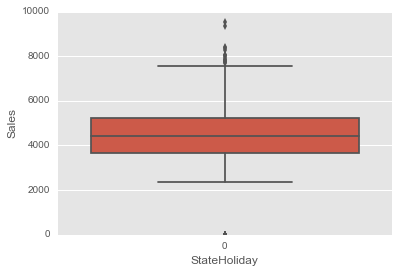

In [41]:
df_non_holidays = df[df['StateHoliday'] == '0']

sb.boxplot(data=df_non_holidays, x = 'StateHoliday', y = 'Sales');

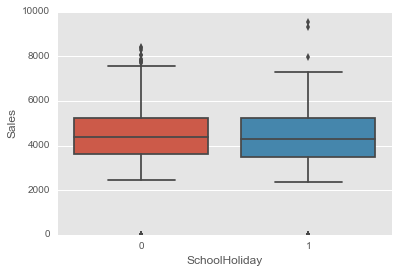

In [42]:
sb.boxplot(x='SchoolHoliday', y='Sales', data=df);

> Check: See if there is a difference affecting sales on promotion days.

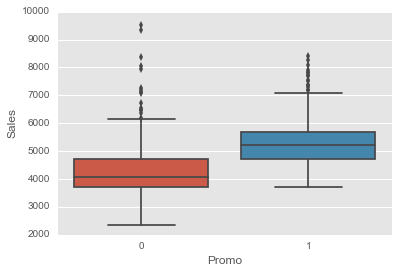

In [43]:
df_store_open = df[df['Open'] == 1] 

sb.boxplot(x='Promo', y='Sales', data=df_store_open);

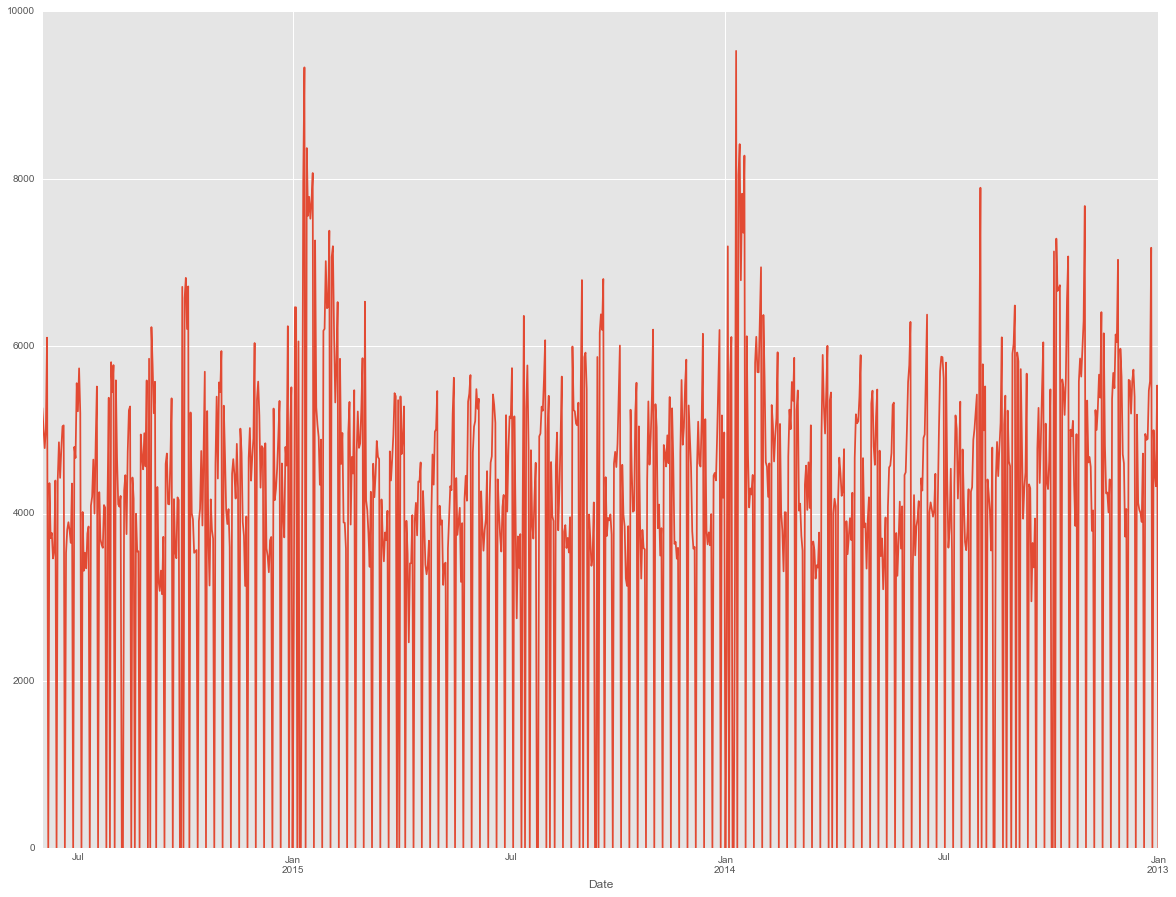

In [71]:
df.Sales.plot(figsize=(20, 15));

## Codealong - Part B: Seasonality, Trends, and Cycles

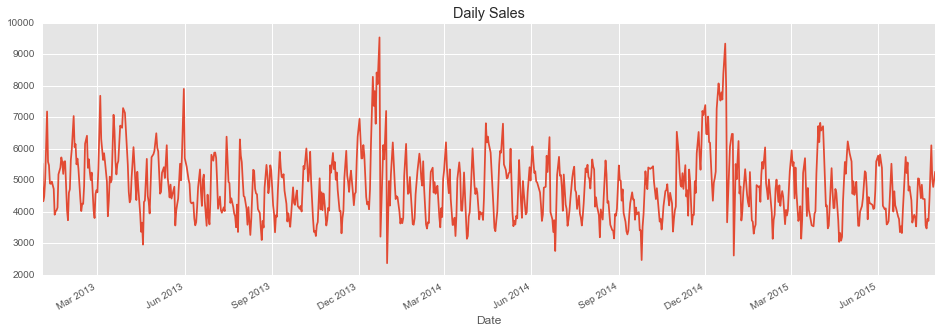

In [44]:
axis = df_store_open.Sales.plot(figsize=(16, 5))

axis.set_title("Daily Sales");

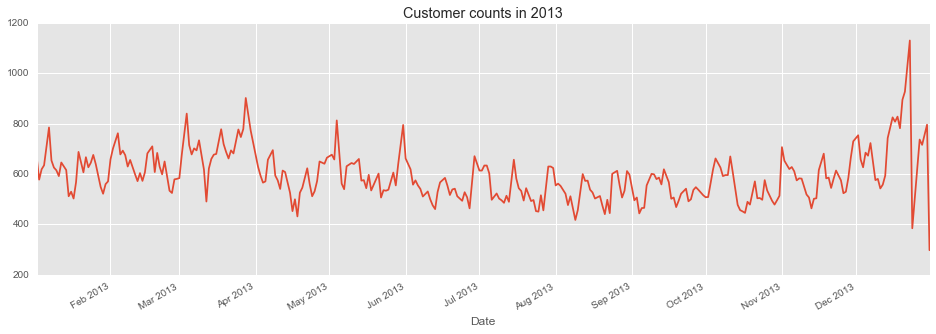

In [45]:
axis = df_store_open[df_store_open.Year == 2013].Customers.plot(figsize=(16, 5))

axis.set_title("Customer counts in 2013");

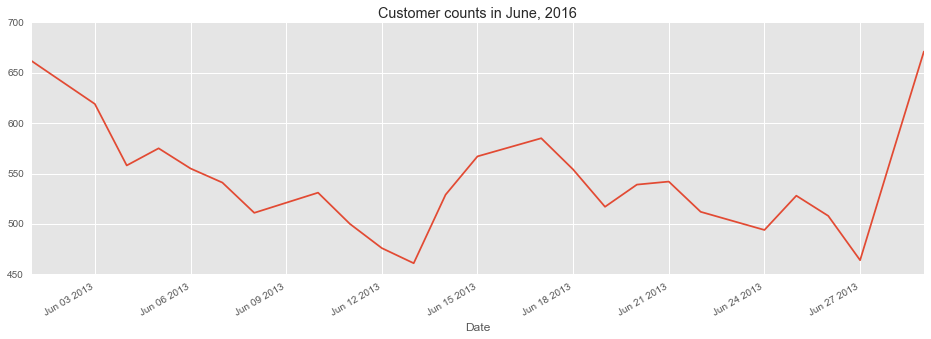

In [46]:
axis = df_store_open[(df_store_open.Year == 2013) & (df_store_open.Month == 6)].Customers.plot(figsize=(16, 5))

#  format='%Y%m%d'
# pd.to_datetime?

axis.set_title("Customer counts in June, 2016");

## Codealong - Part C: Rolling Averages; `pandas` Window and Expanding Functions

In `pandas`, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

### Rolling averages

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  What were the mean and median sales for each month and year?

In `pandas`, this is performed using the `resample` command, which is very similar to the `groupby` command.  It allows us to group over different time intervals.

We can use `df.resample` and provide as arguments:
- The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
- What aggregation to perform: 'mean', 'median', 'sum', etc.

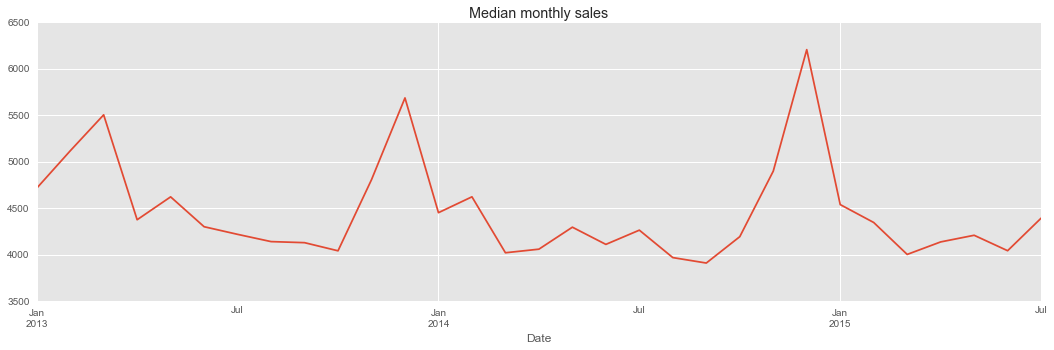

In [52]:
# plt.figure(figsize=(18, 5))
# df.Sales.plot()

plt.figure(figsize=(18, 5))
df_median_monthly_sales = df.Sales.resample('M').median()

axis = df_median_monthly_sales.plot();

axis.set_title("Median monthly sales");

While identifying the monthly averages is useful, we often want to compare the sales data of a date to a smaller window.  To understand holidays sales, we don't want to compare late December with the entire month, but perhaps with a few days surrounding it.  We can do this using rolling averages.

In `pandas`, we can compute rolling average using the `pd.rolling` function.

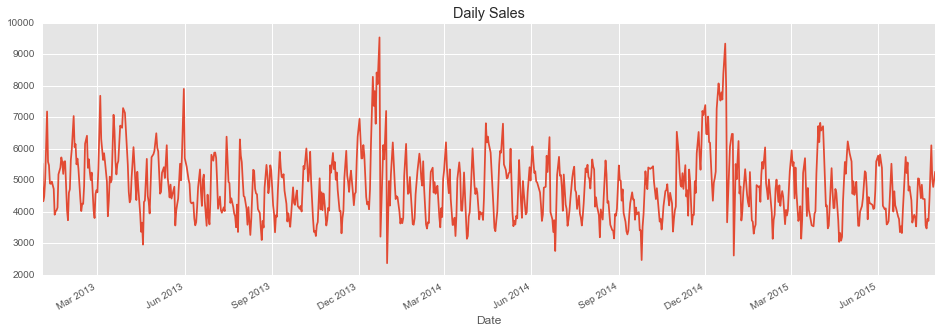

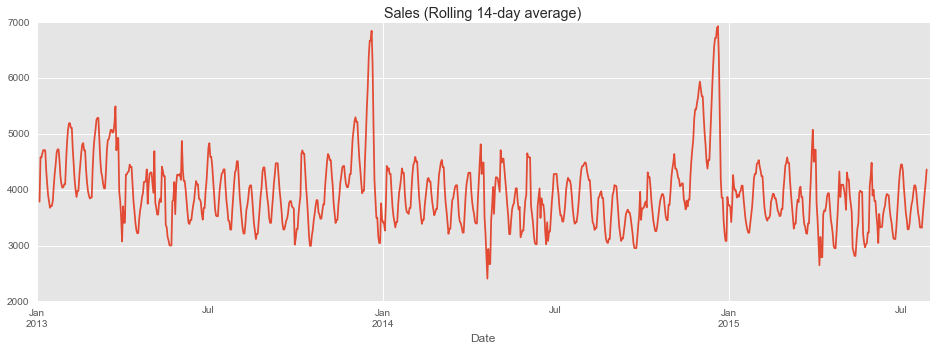

In [56]:
df_rolling_sales_3_day_mean = df.Sales.rolling(window = 7, center = True, freq = 'D').mean()

axis = df_store_open.Sales.plot(figsize=(16, 5));
axis.set_title("Daily Sales")

plt.figure()
rolling_sales_axis = df_rolling_sales_3_day_mean.plot(figsize=(16, 5));
rolling_sales_axis.set_title("Sales (Rolling 14-day average)");

`rolling_mean` (as well as `rolling_median`) takes these important parameters:
- `window` is the number of days to include in the average
- `center` is whether the window should be centered on the date or use data prior to that date
- `freq` is on what level to roll-up the averages to (as used in `resample`).  Either `D` for day, `M` for month or `A` for year, etc.

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

### `pandas` window functions

`pandas` `rolling_mean` and `rolling_median` are only two examples of `pandas` window function capabilities.  Window functions are operate on a set of N consecutive rows (a window) and produce an output.

In addition to `rolling_mean` and `rolling_median`, there are `rolling_sum`, `rolling_min`, `rolling_max`... and many more.

Another common one is `diff`, which takes the difference over time.  `pd.diff` takes one arugment, `periods`, which is how many rows prior to use for the difference.

In [59]:
df.Sales.head()

Date
2015-07-31    5263
2015-07-30    5020
2015-07-29    4782
2015-07-28    5011
2015-07-27    6102
Name: Sales, dtype: int64

In [57]:
df.Sales.diff(periods = 1).head()

Date
2015-07-31       NaN
2015-07-30    -243.0
2015-07-29    -238.0
2015-07-28     229.0
2015-07-27    1091.0
Name: Sales, dtype: float64

### `pandas` expanding functions

In addition to the set of `rolling_*` functions, `pandas` also provides a similar collection of `expanding_*` functions, which, instead of using a window of N values, use all values up until that time.

In [61]:
df.Sales.head()

Date
2015-07-31    5263
2015-07-30    5020
2015-07-29    4782
2015-07-28    5011
2015-07-27    6102
Name: Sales, dtype: int64

In [60]:
# computes the average sales, from the first date _until_ the date specified.

df.Sales.expanding(min_periods=1, freq = 'd').mean().head()

Date
2013-01-01       0.000000
2013-01-02    2765.000000
2013-01-03    3285.666667
2013-01-04    3585.750000
2013-01-05    3868.000000
Freq: D, Name: Sales, dtype: float64

## Codealong - Part D: Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column.  In `pandas`, we do this we with the `autocorr` function:

`autocorr` takes one argument, the `lag` which is how many prio data points should be used to compute the correlation.  If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it.  Setting `lag` to 10 computes the correlation between every point and the point 10 days earlier.

In [65]:
print "Autocorrelation (Day-to-day)", df.Sales.autocorr(lag = 1)
print "Autocorrelation (Day-to-day)", df.Sales.autocorr(lag = 2)
print "Autocorrelation (Day-to-day)", df.Sales.autocorr(lag = 3)
print "Autocorrelation (Day-to-day)", df.Sales.autocorr(lag = 4)
print "Daily Autocorrelation (7-day cycle)", df.Sales.autocorr(lag = 7)

Autocorrelation (Day-to-day) -0.127325143391
Autocorrelation (Day-to-day) -0.0347871557079
Autocorrelation (Day-to-day) 0.064736112913
Autocorrelation (Day-to-day) -0.00181144791099
Daily Autocorrelation (7-day cycle) 0.630719243284


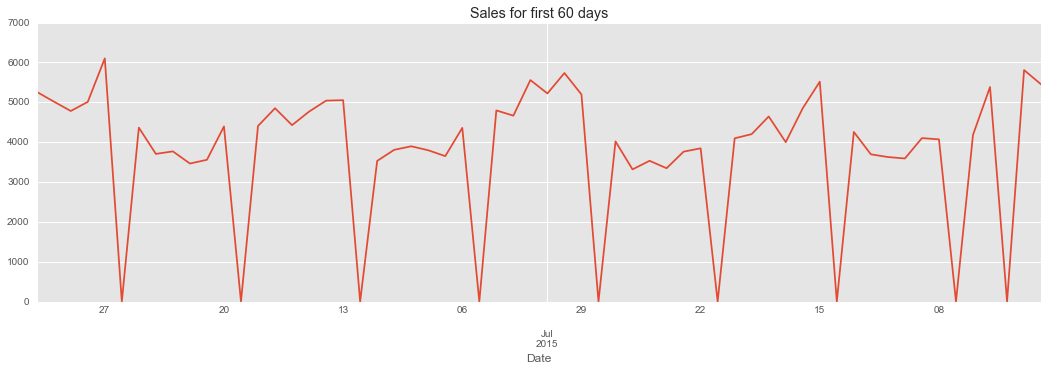

In [63]:
plt.figure(figsize=(18, 5))

axis = df[:60].Sales.plot()
axis.set_title("Sales for first 60 days");

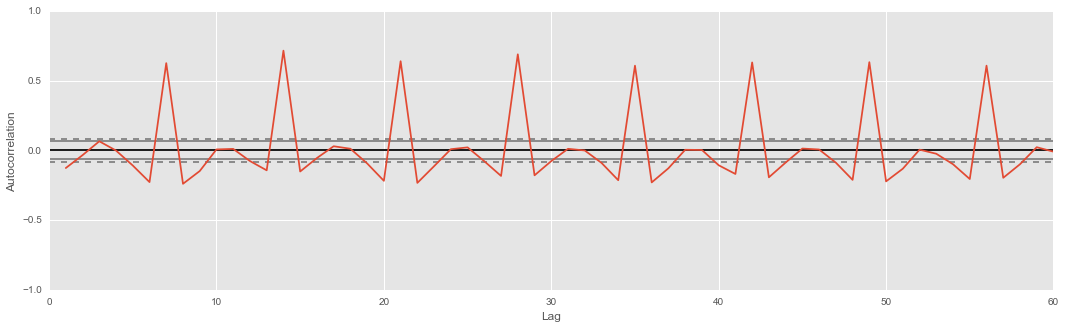

In [66]:
from pandas.tools.plotting import autocorrelation_plot

plt.figure(figsize=(18, 5))
axis = autocorrelation_plot(df.Sales)
axis.set_xlim(left=0, right=60)
axis.grid(axis='both');

## Lab

> Question 1.  Plot the distribution of sales by month and compare the effect of promotions

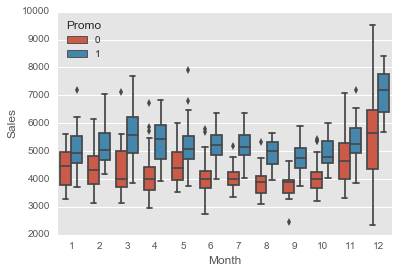

In [73]:
sb.boxplot(hue = 'Promo',
    x = 'Month',
    y = 'Sales',
    data = df_store_open);

> Question 2.  Are sales more correlated with the prior date, a similar date last year, or a similar date last month?

In [75]:
print "Autocorrelation (Day-to-day)", df.Sales.autocorr(lag = 1)
print "Autocorrelation (Year-to-year)", df.Sales.autocorr(lag = 365)
print "Autocorrelation (Month to Month)", df.Sales.autocorr(lag = 28)
print "Autocorrelation (Month to Month)", df.Sales.autocorr(lag = 29)
print "Autocorrelation (Month to Month)", df.Sales.autocorr(lag = 30)
print "Autocorrelation (Month to Month)", df.Sales.autocorr(lag = 31)


Autocorrelation (Day-to-day) -0.127325143391
Autocorrelation (Year-to-year) -0.0581932157053
Autocorrelation (Month to Month) 0.706103781139
Autocorrelation (Month to Month) -0.184019424822
Autocorrelation (Month to Month) -0.0794070299952
Autocorrelation (Month to Month) 0.0108948483946


> Question 3.  Plot the 15 day rolling mean of customers in the stores

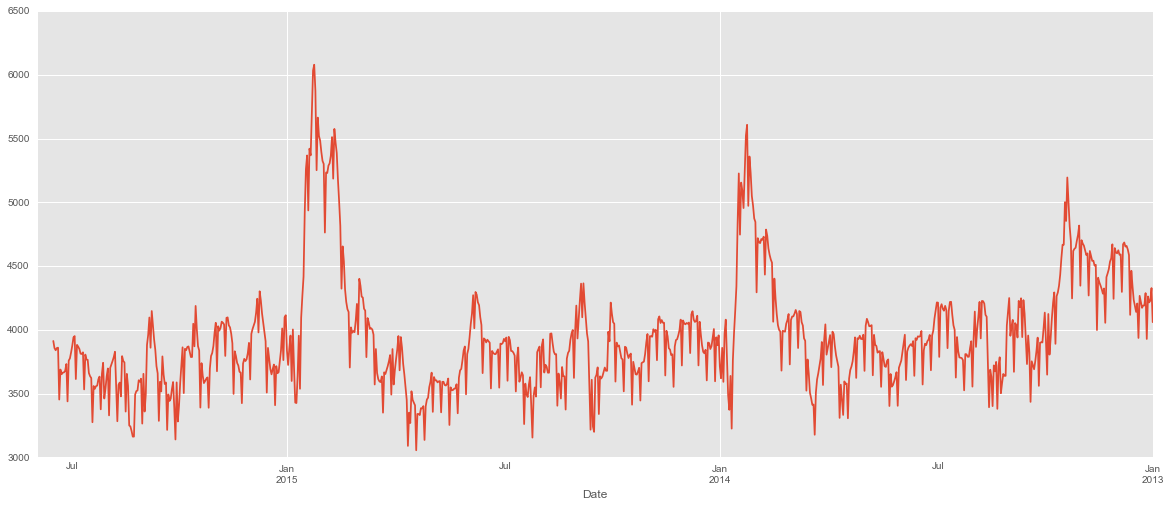

In [78]:
df.Sales.rolling(15).mean().plot(figsize=(20, 8));

> Question 4.  Identify the dates with largest drop in sales from the same date in the previous month

In [86]:
rolling_weekly_diff = df.Sales.diff(periods = 28);

rolling_weekly_diff.nlargest(10)

Date
2013-03-04    7675.0
2014-11-28    7195.0
2014-12-04    7016.0
2013-05-02    6486.0
2014-11-27    6144.0
2013-12-04    5688.0
2013-04-22    5672.0
2014-12-22    5610.0
2015-04-27    5575.0
2015-03-06    5397.0
Name: Sales, dtype: float64

> Question 5.  Compute the total sales up until December 2014

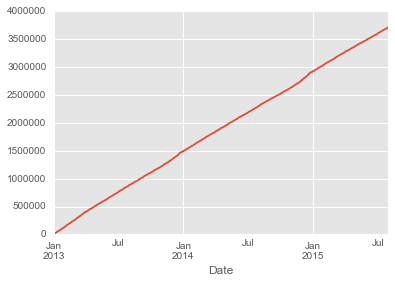

In [94]:
cumulative_sum_sales = df[(df.Year <= 2015)].Sales.expanding(min_periods=1, freq = 'd').sum()

cumulative_sum_sales.plot();

> Question 6.  When were the largest differences between 15-day moving/rolling averages?
> HINT: Using `rolling_mean` and `diff`

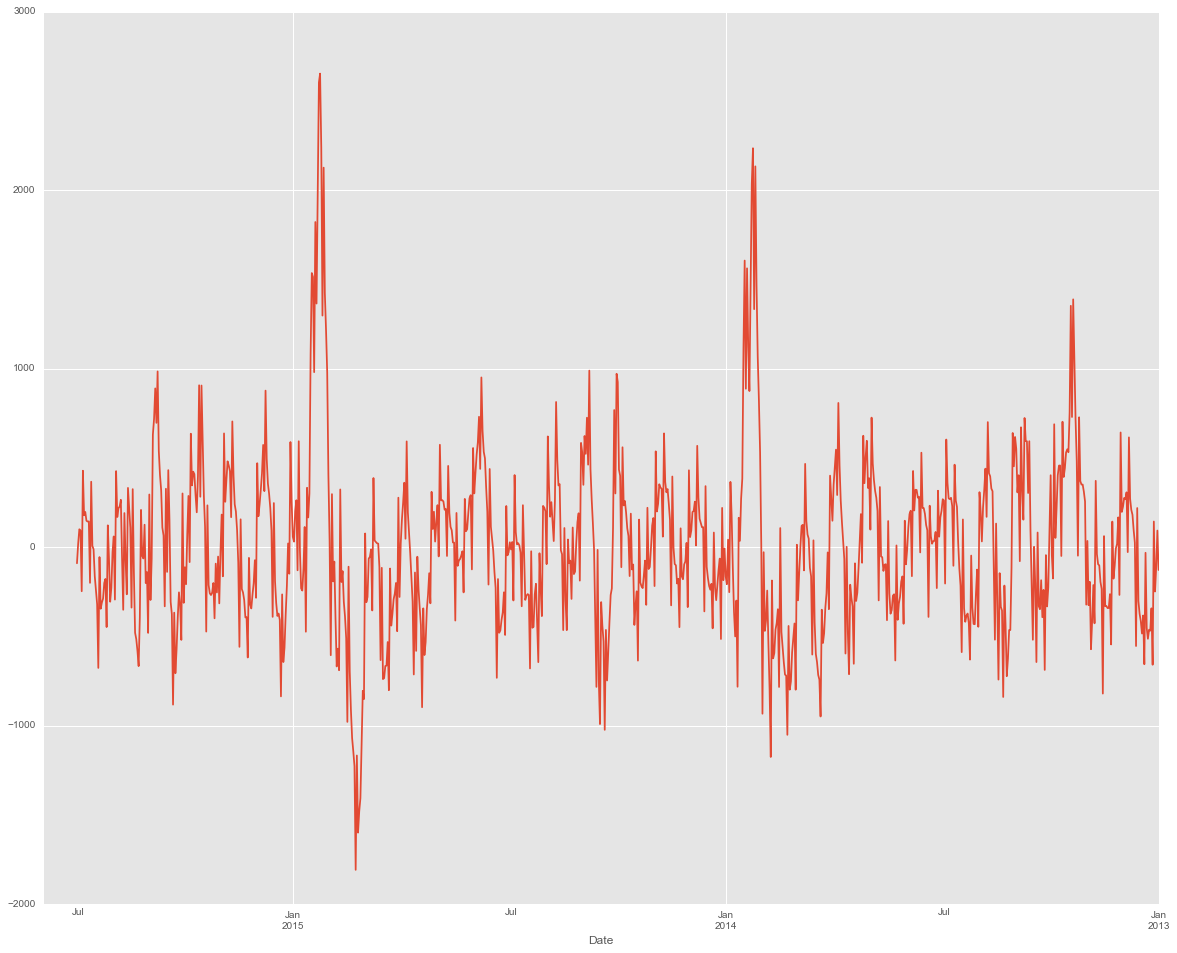

In [100]:
rolling_diff_mean = df.Sales.rolling(15).mean().diff(periods = 15)

rolling_diff_mean.plot(figsize=(20, 16))